# LAB3

In [6]:
import numpy as np
import math
import scipy.io


from sklearn.cluster import KMeans
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import time

img0=cv2.imread('bird_small.tiff')
img0=cv2.cvtColor(img0,cv2.COLOR_BGR2RGB)

img=np.asarray(img0.reshape((img0.shape[1]*img0.shape[0],3)))

# isolating each color component of the image
img_red = [pixel[0] for pixel in img]
img_green = [pixel[1] for pixel in img]
img_blue = [pixel[2] for pixel in img]

In [7]:
# returns the contingency matrix between two same-sized arrays
# by counting occurencies in each one, and dividing by the dimension so as to get probabilities
def getContingencyMatrix(array1,array2):
    dim = len(array1)
    matrix = np.zeros((256,256))
    for i in range(dim):
        b0,b1 = array1[i],array2[i]
        matrix[b0][b1]+=1
    return matrix/dim

In [8]:
# fetching the contingency matrices of eanch color component
matrix_rg = getContingencyMatrix(img_red, img_green)
matrix_rb = getContingencyMatrix(img_red, img_blue)
matrix_gb = getContingencyMatrix(img_green, img_blue)

In [ ]:
# returns the entropy from a distribution vector
def getEntropy(distr):
    entropy = 0
    for p_k in distr.values():
        if (p_k!=0):
            entropy -= p_k * math.log2(p_k)
    return entropy

# returns the marginal pdf by summing on each line
def getMarginalPdfX(mat):
    p_x = {}
    k = 0
    for line in mat:
        p_x[k] = np.sum(line)
        k+=1
    return p_x

# return the marginal pdf by summing each column
# just by transposing the matrix
def getMarginalPdfY(mat):
    return getMarginalPdfX(np.transpose(mat))

# basically returns the whole contingency matrix but as a dictionnary for easier access, 
# as the function getContingencyMatrix() already returns a distribution
def getJointPdfXY(mat):
    p_xy = {}
    dim = len(mat)
    for b0 in range(dim):
        for b1 in range(dim):
            p_xy[b0,b1] = mat[b0][b1]
    return p_xy

## 1 - Mutual information  
  
Following the formula :  
$$ I(A,B) = \sum_{k=0}^{K-1}\sum_{j=0}^{J-1}P(x_j, y_k) \cdot \frac{P(x_j,y_k)}{P(x_j)P(y_k)} $$  
with : 
 * $P(x_j,y_k)$ the joint pdf
 * $P(x_j)$ and $P(y_k)$ the marginal pdfs

In [9]:
# returns the mutual information between two arrays, based on their contingency matrix
def getMutualInformation(mat):
    
    # the dimension is here the number of values a pixel can take (1-dimensional pixel)
    dim = 255

    # calculating the partial pdfs
    # (the joint pdf is the contingency matrix)
    p_x = list(getMarginalPdfX(mat).values())
    p_y = list(getMarginalPdfY(mat).values())

    mutualInformation = 0

    for i in range(dim):
        for j in range(dim):
            if mat[i][j] != 0:
                mutualInformation += mat[i][j]*math.log2(mat[i][j]/(p_x[i]*p_y[j]))
    return mutualInformation

## 2 - Normalized Mutual Information  
  
Following the formula : 
$$ NMI(x,y) = \frac{2 \cdot I(x,y)}{H(x)+H(y)} $$

In [10]:
# returns the normalized mutual information
def getNMI(mat):
    p_x = getMarginalPdfX(mat)
    p_y = getMarginalPdfY(mat)
    H_x = getEntropy(p_x)
    H_y = getEntropy(p_y)
    mutualInformation = getMutualInformation(mat)
    return 2*mutualInformation/(H_x+H_y)

## 3 - NMI between colors

In [11]:
print("NMI red-green :",getNMI(matrix_rg),"\nNMI red-blue :",getNMI(matrix_rb),"\nNMI green-blue :",getNMI(matrix_gb))
#red and blue share the least mutual information

NMI red-green : 0.4116062221651455 
NMI red-blue : 0.34333393786564986 
NMI green-blue : 0.370662291066007


## 4 - NMI between colors of kmeans-processed images

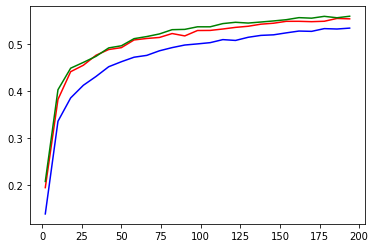

In [6]:
# now we repeat the previous process, except we will use images processed through a k-means algorithm with 
# an increasing number of centroids, and compare the NMI between said images and the original

k = []
nmi_red_array = []
nmi_green_array = []
nmi_blue_array = []

for i in range(2,200,8):
    kmeans=KMeans(n_clusters=i).fit(img)

    labels=kmeans.labels_
    centroid=kmeans.cluster_centers_
    
    #rebuilding the actual values of pixels
    flat_kmeans_img = []
    for label in labels:
        flat_kmeans_img.append(centroid[label].astype(int))
    
    img_kmeans_red = [pixel[0] for pixel in flat_kmeans_img]
    img_kmeans_green = [pixel[1] for pixel in flat_kmeans_img]
    img_kmeans_blue = [pixel[2] for pixel in flat_kmeans_img]
    
    #getting contignecy matrices between the real image and the kmeans'd image
    matrix_rr = getContingencyMatrix(img_red, img_kmeans_red)
    matrix_gg = getContingencyMatrix(img_green, img_kmeans_green)
    matrix_bb = getContingencyMatrix(img_blue, img_kmeans_blue)
    
    #creating arrays of NMI
    nmi_red_array.append(getNMI(matrix_rr))
    nmi_green_array.append(getNMI(matrix_gg))
    nmi_blue_array.append(getNMI(matrix_bb))
    k.append(i)
    
plt.plot(k, nmi_red_array,color="red")
plt.plot(k, nmi_green_array,color="green")
plt.plot(k, nmi_blue_array,color="blue")

# as expected, the mutual information between the original image colors and the kmeans'd image rises 
# in a logarithmic fashion, as the number of clusters gets higher.
# (the whole process is quite long)

## 5 - NMI between DNAs

In [8]:
# class to represent and parse the .mat file containing the DNA
class dnaDB():
    
    def __init__(self, path):
        self.mat = scipy.io.loadmat(path)
        self.db = {}
        self.total = len(self.mat["label"])
        for k in range(len(self.mat["label"])):
            self.db[ self.mat["label"][k][0][0] ] = self.mat["str"][k]
            
    def getSpecie(self, index):
        return self.mat["label"][index][0]
    
    def getSpecies(self):
        return [self.getSpecie(k)[0] for k in range(self.total)]
    
    def getDNA(self, animal):
        return self.db[animal]

In [9]:
# class to process, compare and analyze a DNA with another
class DNA():
    
    def __init__(self, animal, db):
        self.dna = db.getDNA(animal)
        self.animal = animal
        self.bases = {"A":0, "T":1, "G":2, "C":3, "-":4}
        
    def getContingencyMatrix(self,dna_):
        dim = len(self.dna)
        matrix = np.zeros((5,5))
        for i in range(dim):
            b0,b1 = self.bases[self.dna[i]],self.bases[dna_.dna[i]]
            matrix[b0][b1]+=1
        return matrix/dim

    def getMarginalPdfX(self,dna_):
        mat = self.getContingencyMatrix(dna_)
        p_x = {}
        k = 0
        for line in mat:
            p_x[k] = np.sum(line)
            k+=1
        return p_x

    def getMarginalPdfY(self,dna_):
        mat = np.transpose(self.getContingencyMatrix(dna_))
        p_y = {}
        k = 0
        for line in mat:
            p_y[k] = np.sum(line)
            k+=1
        return p_y
    
    def getJointPdfXY(self, dna_):
        p_xy = {}
        mat = self.getContingencyMatrix(dna_)
        dim = len(mat)
        for b0 in range(dim):
            for b1 in range(dim):
                p_xy[b0,b1] = mat[b0][b1]
        return p_xy

    def getMutualInformation(self, dna_):
        
        dim = len(self.bases)
        mat = self.getContingencyMatrix(dna_)
        #on peut se passer d'elle vu qu'il s'agit des valeurs dans la matrice
        #p_xy = self.getJointPdfXY(dna_)

        p_x = list(self.getMarginalPdfX(dna_).values())
        p_y = list(self.getMarginalPdfY(dna_).values())
        
        mutualInformation = 0

        for i in range(dim):
            for j in range(dim):
                if mat[i][j] != 0:
                    mutualInformation += mat[i][j]*math.log2(mat[i][j]/(p_x[i]*p_y[j]))
        return mutualInformation
    
    def getNMI(self, dna_):
        p_x = self.getMarginalPdfX(dna_)
        p_y = self.getMarginalPdfY(dna_)
        H_x = self._getEntropy(p_x)
        H_y = self._getEntropy(p_y)
        mutualInformation = self.getMutualInformation(dna_)
        return 2*mutualInformation/(H_x+H_y)
        
        
    def _getEntropy(self,distr):
        entropy = 0
        for p_k in distr.values():
            if (p_k!=0):
                entropy -= p_k * math.log2(p_k)
        return entropy

In [10]:
# crating a new DNA database
database = dnaDB("DNA_species.mat")

# loading different DNAs
humanDNA = DNA("Human", database)
whaleDNA = DNA("Whale", database)

# NMI between those two DNAs
print(humanDNA.getNMI(whaleDNA))

0.35930238744618453


In [12]:
# now we repeat the same comparison process between all the species
# and fetching the max NMI by the same occasion
species = database.getSpecies()
maxNMI,ms1,ms2 = 0,"",""

for s1 in species:
    for s2 in species:
        
        if s1!=s2:
            dna1 = DNA(s1,database)
            dna2 = DNA(s2,database)
            nmi = dna1.getNMI(dna2)
            
            if nmi>maxNMI:
                maxNMI = nmi
                ms1 = s1
                ms2 = s2
                
            print("NMI between",s1,"and",s2,":",nmi)
            
print("\nMax NMI reached between",ms1,"and",ms2,"with NMI =",maxNMI)

NMI between Cow and Carp : 0.3261698432152613
NMI between Cow and Chicken : 0.3521306555888597
NMI between Cow and Human : 0.32510514866079543
NMI between Cow and Loach : 0.3333351635605638
NMI between Cow and Mouse : 0.5218026932872569
NMI between Cow and Rat : 0.5464150476467522
NMI between Cow and Seal : 0.5669492617271653
NMI between Cow and Whale : 0.5949575951285525
NMI between Cow and Frog : 0.36957419470983727
NMI between Carp and Cow : 0.3261698432152612
NMI between Carp and Chicken : 0.31557401191290907
NMI between Carp and Human : 0.26998119675373755
NMI between Carp and Loach : 0.5039846585069331
NMI between Carp and Mouse : 0.32837358024947955
NMI between Carp and Rat : 0.32716029708832334
NMI between Carp and Seal : 0.3291562222168901
NMI between Carp and Whale : 0.35424960799306193
NMI between Carp and Frog : 0.42437839584620585
NMI between Chicken and Cow : 0.3521306555888597
NMI between Chicken and Carp : 0.31557401191290907
NMI between Chicken and Human : 0.3040088663